- $l=0.2, \sigma=0.3$
- $n_{sensors}=11, 21, 41$
- $dim_\epsilon=10, 15$
- $n_{samples}=500, 1000$

In [1]:
import time
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from scipy import io
import math
import itertools
import seaborn as sns
import os

In [2]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_dim, out_dim, mask, Siren=False):
        super(MaskedLinear, self).__init__(in_dim, out_dim)
        self.mask = mask
        if Siren:
            c = torch.sqrt(torch.tensor(6., dtype=torch.double))
            numerator = torch.sqrt(torch.tensor(in_dim, dtype=torch.double))
            nn.init.uniform_(self.weight, a=-c/numerator, b=c/numerator)
            nn.init.zeros_(self.bias)
        else:
            nn.init.xavier_uniform_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, input):
        self.mask = self.mask.to(self.weight.device)
        return F.linear(input, self.weight*self.mask, self.bias)
        
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False, Siren=False, num_stack=4, is_mask=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if i>0 and is_mask:
                mask = torch.zeros([neurons[i+1], neurons[i]], dtype=torch.double)
                len_in = neurons[i]//num_stack
                len_out = neurons[i+1]//num_stack
                for j in range(num_stack):
                    ##neurons 개수가 num stack으로 나누어 떨어지지 않을 수도 있다. 이 경우 마지막을 꽉 채워줘야 함
                    if j<num_stack-1:
                        mask[j*len_out:(j+1)*len_out,j*len_in:(j+1)*len_in] = 1
                    else:
                        mask[j*len_out:,j*len_in:] = 1
                if spectral:
                    self.dense[str(i)] = spectral_norm(MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double())
                else:
                    self.dense[str(i)] = MaskedLinear(neurons[i], neurons[i+1], mask=mask, Siren=Siren).double()
            else:
                if spectral:
                    self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]).double())
                else:
                    self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1]).double()
                    
                if Siren:
                    c = torch.sqrt(torch.tensor(6.))
                    numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                    nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                    nn.init.zeros_(self.dense[str(i)].bias)
                else:
                    nn.init.xavier_uniform_(self.dense[str(i)].weight)
                    nn.init.zeros_(self.dense[str(i)].bias)
            
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
class WGAN_SN():
    def __init__(self, eps_dim, activation, save_path, Siren=False, n_k=None, n_u=None, p_k=None, n_b_k=None, n_t_k=None, p_u=None, n_b_u=None, n_t_u=None, exp=False,
                is_mask=False, num_stack={'k':4,'u':4}):
        torch.manual_seed(0)
        self.exp = exp
        self.eps_dim = eps_dim

        if n_k!= None:
            self.net_k = DNN(n_k, activation = activation['k'], Siren=Siren)
        if n_u!= None:
            self.net_u = DNN(n_u, activation = activation['u'], Siren=Siren)
        if p_k!=None:
            self.p_k = p_k
            self.n_b_k = n_b_k
            self.n_t_k = n_t_k

            self.net_t_k = DNN(n_t_k, activation = activation['k'], Siren=Siren)
            self.net_b_k = DNN(n_b_k, activation = activation['k'], Siren=Siren, is_mask=is_mask, num_stack=num_stack['k'])

        if p_u!=None:
            self.p_u = p_u
            self.n_b_u = n_b_u
            self.n_t_u = n_t_u

            self.net_t_u = DNN(n_t_u, activation = activation['u'], Siren=Siren)
            self.net_b_u = DNN(n_b_u, activation = activation['u'], Siren=Siren, is_mask=is_mask, num_stack=num_stack['u'])
        
        self.path = save_path

    def predict_k_NC(self, X, n_tile, time=False):
        n_sensors = X.shape[1]

        X = X.T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double)
        k_pred_t = self.net_t_k.activation(self.net_t_k(X)).T
        k_pred_b = self.net_b_k(eps)
        k_pred = torch.matmul(k_pred_b, k_pred_t).detach()
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2
        if time:
            return k_pred
        
        k_mean, k_std = k_pred.mean(0), k_pred.std(0)
        return k_pred, k_mean, k_std
    
    def predict_u_NC(self, X, n_tile, time=False):
        n_sensors = X.shape[1]
        
        X = X.T.to(next(self.net_t_u.parameters()).device)
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double).to(next(self.net_t_u.parameters()).device)
        u_pred_t = self.net_t_u.activation(self.net_t_u(X)[:,:self.p_u]).T
        u_pred_b = self.net_b_u(eps)
        u_pred = (torch.matmul(u_pred_b, u_pred_t)*(1-(X[:,:1].T)**2)*(1-(X[:,1:].T)**2)).detach()
        if time:
            return u_pred
        
        u_mean, u_std = u_pred.mean(0), u_pred.std(0)
        return u_pred, u_mean, u_std
    
    def predict_k_FC(self, X, n_tile, time=False):
        n_sensors = X.shape[1]

        X = X.to(next(self.net_k.parameters()).device)
        X = X.repeat([1,n_tile]).T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double, device = next(self.net_k.parameters()).device)
        eps = eps.repeat([1,n_sensors]).reshape(-1,self.eps_dim)
        k_pred = self.net_k(X,eps).detach().reshape(-1,n_sensors)
        if self.exp:
            k_pred = torch.exp(k_pred) + 1/2
        if time:
            return k_pred

        k_mean, k_std = k_pred.mean(0), k_pred.std(0)
        return k_pred, k_mean, k_std

    def predict_u_FC(self, X, n_tile, time=False):
        n_sensors = X.shape[1]
        
        X = X.to(next(self.net_u.parameters()).device)
        X = X.repeat([1,n_tile]).T
        eps = torch.randn([n_tile, self.eps_dim], dtype=torch.double, device = next(self.net_u.parameters()).device)
        eps = eps.repeat([1,n_sensors]).reshape(-1,self.eps_dim)
        u_pred = (1-X[:,:1]**2)*(1-X[:,1:]**2)*self.net_u(X,eps)[:,:1]
        u_pred = u_pred.detach().reshape(-1,n_sensors)
        if time:
            return u_pred

        u_mean, u_std = u_pred.mean(0), u_pred.std(0)
        return u_pred, u_mean, u_std

    def make_cov(self, k, n_sensors):
        k = k.reshape(-1, n_sensors)
        k_mean = k.mean(0)
        k_center = (k - k_mean)
        for i in range(n_sensors):
            tmp = k_center*k_center[:,i:i+1]
            tmp = tmp.mean(0).reshape(-1,1)
            if i==0:
                cov = tmp
            else:
                cov = torch.cat([cov, tmp], 1)
        return k_mean, cov

In [4]:
def to_torch(*args):
    res = []
    for comp in args:
        res.append(torch.from_numpy(comp).double())
    if len(res)==1:
        res = res[0]
    return res
    
torch.manual_seed(0)

X_dim=2
u_dim=1#u_dim이 곧 k_dim
lc = 1.0
sigma=0.3
eps_dim=3
k_sensors=121
f_sensors=121

M=101
n_sensors_test = M
n_tile_test=100000

##test data
with open(f'test_data_2d_{lc}lc_{sigma}sigma_origin.pkl', 'rb') as ff:
    test_data = pickle.load(ff)
x_ref = to_torch(test_data['x'])
k_mean_ref, k_std_ref = to_torch(test_data['k_mean'], test_data['k_std'])
u_mean_ref, u_std_ref = to_torch(test_data['u_mean'], test_data['u_std'])

result_path = f'Result_SPDE_{lc}lc'
if not os.path.isdir(result_path):                                                           
    os.mkdir(result_path)

In [5]:
x_ref.shape

torch.Size([2, 10201])

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [7]:
# torch.manual_seed(0)

# activation={'disc':F.relu, 'k':torch.sin, 'u':torch.sin}
# fig_losses, axes_losses = plt.subplots(1,2, figsize=(12,6))

# name = 'one-discriminator'
# save_path = f'SPDE_2d_{k_sensors,f_sensors}sensors_onedisc'
# losses = torch.load(save_path+'/validation_error')
# index = torch.arange(0,losses['total_epoch'],losses['n_loss'])
# mean_loss_k = losses['mean_loss_k']
# std_loss_k = losses['std_loss_k']
# axes_losses[0].semilogy(index, mean_loss_k, label=name)
# axes_losses[1].semilogy(index, std_loss_k, label=name)

# name = 'multi-discriminator'
# save_path = f'SPDE_2d_{k_sensors,f_sensors}sensors_multidisc'
# losses = torch.load(save_path+'/validation_error')
# index = torch.arange(0,losses['total_epoch'],losses['n_loss'])
# mean_loss_k = losses['mean_loss_k']
# std_loss_k = losses['std_loss_k']
# axes_losses[0].semilogy(index, mean_loss_k, label=name)
# axes_losses[1].semilogy(index, std_loss_k, label=name)

# for i in range(2):
#     axes_losses[i].legend()
# axes_losses[0].set_title('mean loss')
# axes_losses[1].set_title('standard deviation loss')
# axes_losses[0].set_xlabel('epoch')
# axes_losses[1].set_xlabel('epoch')
# # fig_losses.savefig('PDE_2D_l=1.0_losses.pdf', bbox_inches='tight')
# fig_losses.show()

In [8]:
with open(result_path+'/results.pkl', 'rb') as ff:
    results = pickle.load(ff)
    
k_mean = results['k_mean']
k_std = results['k_std']
er_mean_k = results['er_mean_k']
er_std_k = results['er_std_k']
u_mean = results['u_mean']
u_std = results['u_std']
er_mean_u = results['er_mean_u']
er_std_u = results['er_std_u']
NC_time_mean_N_fixed=results['time_cost_fix_N']['time_NC_mean_fix_N']
NC_time_std_N_fixed=results['time_cost_fix_N']['time_NC_std_fix_N']
FC_time_mean_N_fixed=results['time_cost_fix_N']['time_FC_mean_fix_N']
FC_time_std_N_fixed=results['time_cost_fix_N']['time_FC_std_fix_N']
NC_time_mean_m_fixed=results['time_cost_fix_m']['time_NC_mean_fix_m']
NC_time_std_m_fixed=results['time_cost_fix_m']['time_NC_std_fix_m']
FC_time_mean_m_fixed=results['time_cost_fix_m']['time_FC_mean_fix_m']
FC_time_std_m_fixed=results['time_cost_fix_m']['time_FC_std_fix_m']

m_time = [5, 7, 10, 14]
N_time = [1000, 2000, 3000, 4000]

In [9]:
FC_time_mean_N_fixed/NC_time_mean_N_fixed

tensor([26.1792, 11.9059, 17.1443, 23.6340])

In [10]:
FC_time_mean_m_fixed/NC_time_mean_m_fixed

tensor([ 9.6679, 17.0095, 24.3186, 31.6683])

In [11]:
# #NC

# torch.manual_seed(0)
# k_mean = {}
# k_std = {}
# u_mean = {}
# u_std = {}

# er_mean_k = {}
# er_std_k = {}
# er_mean_u = {}
# er_std_u = {}

# activation={'disc':F.relu, 'k':torch.sin, 'u':torch.sin}
# fig_QoI, axes_QoI = plt.subplots(2,2, figsize=(12,12))

# n_k = [X_dim+eps_dim, 128, 128, 1]
# n_u = [X_dim+eps_dim, 128, 128, (X_dim+1)]
# name = 'FC'
# save_path = f'SPDE_FC_onedisc'

# model = WGAN_SN(eps_dim, activation, save_path, Siren=True, exp=True, n_k=n_k, n_u=n_u)
# model.net_k.load_state_dict(torch.load(save_path+'/net_k'))
# model.net_u.load_state_dict(torch.load(save_path+'/net_u'))

# mini_size = 10
# mini_tile = n_tile_test//mini_size
# with torch.no_grad():
#     _, k_mean[name], k_std[name] = model.predict_k_FC(x_ref, mini_tile)
#     _, u_mean[name], u_std[name] = model.predict_u_FC(x_ref, mini_tile)
# for i in range(1,mini_size):
#     with torch.no_grad():
#         _, k_mean_tmp, k_std_tmp = model.predict_k_FC(x_ref, mini_tile)
#         _, u_mean_tmp, u_std_tmp = model.predict_u_FC(x_ref, mini_tile)
#     k_mean[name] = k_mean[name]+k_mean_tmp
#     k_std[name] = k_std[name]+k_std_tmp
#     u_mean[name] = u_mean[name]+u_mean_tmp
#     u_std[name] = u_std[name]+u_std_tmp
# k_mean[name]=k_mean[name]/mini_size
# k_std[name]=k_std[name]/mini_size
# u_mean[name]=u_mean[name]/mini_size
# u_std[name]=u_std[name]/mini_size

# start = 101*25
# end = 101*26
# axes_QoI[0,0].plot(x_ref[1,start:end],k_mean[name][start:end], label='FC')
# axes_QoI[0,1].plot(x_ref[1,start:end],k_std[name][start:end], label='FC')
# axes_QoI[1,0].plot(x_ref[1,start:end],u_mean[name][start:end], label='FC')
# axes_QoI[1,1].plot(x_ref[1,start:end],u_std[name][start:end], label='FC')

# er_mean_k[name] = torch.norm(k_mean[name]-k_mean_ref)/torch.norm(k_mean_ref)
# er_std_k[name] = torch.norm(k_std[name]-k_std_ref)/torch.norm(k_std_ref)
# er_mean_u[name] = torch.norm(u_mean[name]-u_mean_ref)/torch.norm(u_mean_ref)
# er_std_u[name] = torch.norm(u_std[name]-u_std_ref)/torch.norm(u_std_ref)
# print(name+f': {er_mean_k[name]:.3e}, {er_std_k[name]:.3e}, {er_mean_u[name]:.3e}, {er_std_u[name]:.3e}')


# p = 64
# n_b = [eps_dim, 64, 64, p]
# n_t_k = [X_dim, 64, 64, p]
# n_t_u = [X_dim, 64, 64, (X_dim+1)*p]
# name = 'NC one'
# save_path = f'SPDE_NC_onedisc'

# model = WGAN_SN(eps_dim, activation, save_path, Siren=True, exp=True, p_k=p, n_b_k=n_b, n_t_k=n_t_k, p_u=p, n_b_u=n_b ,n_t_u=n_t_u, is_mask=True, num_stack={'k':4,'u':4})
# model.net_t_k.load_state_dict(torch.load(save_path+'/net_t_k'))
# model.net_b_k.load_state_dict(torch.load(save_path+'/net_b_k'))
# model.net_t_u.load_state_dict(torch.load(save_path+'/net_t_u'))
# model.net_b_u.load_state_dict(torch.load(save_path+'/net_b_u'))
# with torch.no_grad():
#     _, k_mean[name], k_std[name] = model.predict_k_NC(x_ref, n_tile_test)
#     _, u_mean[name], u_std[name] = model.predict_u_NC(x_ref, n_tile_test)

# start = 101*25
# end = 101*26
# axes_QoI[0,0].plot(x_ref[1,start:end],k_mean[name][start:end], label='one-discriminator')
# axes_QoI[0,1].plot(x_ref[1,start:end],k_std[name][start:end], label='one-discriminator')
# axes_QoI[1,0].plot(x_ref[1,start:end],u_mean[name][start:end], label='one-discriminator')
# axes_QoI[1,1].plot(x_ref[1,start:end],u_std[name][start:end], label='one-discriminator')

# er_mean_k[name] = torch.norm(k_mean[name]-k_mean_ref)/torch.norm(k_mean_ref)
# er_std_k[name] = torch.norm(k_std[name]-k_std_ref)/torch.norm(k_std_ref)
# er_mean_u[name] = torch.norm(u_mean[name]-u_mean_ref)/torch.norm(u_mean_ref)
# er_std_u[name] = torch.norm(u_std[name]-u_std_ref)/torch.norm(u_std_ref)
# print(name+f': {er_mean_k[name]:.3e}, {er_std_k[name]:.3e}, {er_mean_u[name]:.3e}, {er_std_u[name]:.3e}')


# p = 64
# n_b = [eps_dim, 64, 64, p]
# n_t_k = [X_dim, 64, 64, p]
# n_t_u = [X_dim, 64, 64, (X_dim+1)*p]
# name = 'NC multi'
# save_path = f'SPDE_NC_SoD'


# model = WGAN_SN(eps_dim, activation, save_path, Siren=True, exp=True, p_k=p, n_b_k=n_b, n_t_k=n_t_k, p_u=p, n_b_u=n_b ,n_t_u=n_t_u, is_mask=True, num_stack={'k':4,'u':4})
# model.net_t_k.load_state_dict(torch.load(save_path+'/net_t_k'))
# model.net_b_k.load_state_dict(torch.load(save_path+'/net_b_k'))
# model.net_t_u.load_state_dict(torch.load(save_path+'/net_t_u'))
# model.net_b_u.load_state_dict(torch.load(save_path+'/net_b_u'))
# with torch.no_grad():
#     _, k_mean[name], k_std[name] = model.predict_k_NC(x_ref, n_tile_test)
#     _, u_mean[name], u_std[name] = model.predict_u_NC(x_ref, n_tile_test)

# start = 101*25
# end = 101*26
# axes_QoI[0,0].plot(x_ref[1,start:end],k_mean[name][start:end], label='multi-discriminator')
# axes_QoI[0,1].plot(x_ref[1,start:end],k_std[name][start:end], label='multi-discriminator')
# axes_QoI[1,0].plot(x_ref[1,start:end],u_mean[name][start:end], label='multi-discriminator')
# axes_QoI[1,1].plot(x_ref[1,start:end],u_std[name][start:end], label='multi-discriminator')

# er_mean_k[name] = torch.norm(k_mean[name]-k_mean_ref)/torch.norm(k_mean_ref)
# er_std_k[name] = torch.norm(k_std[name]-k_std_ref)/torch.norm(k_std_ref)
# er_mean_u[name] = torch.norm(u_mean[name]-u_mean_ref)/torch.norm(u_mean_ref)
# er_std_u[name] = torch.norm(u_std[name]-u_std_ref)/torch.norm(u_std_ref)
# print(name+f': {er_mean_k[name]:.3e}, {er_std_k[name]:.3e}, {er_mean_u[name]:.3e}, {er_std_u[name]:.3e}')


# #-------------------------------------------------------------------------------
# axes_QoI[0,0].plot(x_ref[1,start:end],k_mean_ref[start:end], label='reference')
# axes_QoI[0,1].plot(x_ref[1,start:end],k_std_ref[start:end], label='reference')
# axes_QoI[1,0].plot(x_ref[1,start:end],u_mean_ref[start:end], label='reference')
# axes_QoI[1,1].plot(x_ref[1,start:end],u_std_ref[start:end], label='reference')

# axes_QoI[0,0].set_title('mean at x=-0.5')
# axes_QoI[0,1].set_title('standard deviation at x=-0.5')
# axes_QoI[1,0].set_xlabel('y')
# axes_QoI[1,1].set_xlabel('y')
# axes_QoI[0,0].set_ylabel('k')
# axes_QoI[1,0].set_ylabel('u')
# for i in range(2):
#     for j in range(2):
#         axes_QoI[i,j].legend()
# # fig_QoI.savefig('PDE_2D_l=1.0_QoI_x=-0.5.pdf', bbox_inches='tight')
# fig_QoI.show()

In [12]:
# results = {'er_mean_k':er_mean_k, 'er_std_k':er_std_k, 'k_mean':k_mean, 'k_std':k_std,
#           'er_mean_u':er_mean_u, 'er_std_u':er_std_u, 'u_mean':u_mean, 'u_std':u_std}
# with open(result_path+'/results.pkl', 'wb') as ff:
#     pickle.dump(results, ff, pickle.HIGHEST_PROTOCOL)

In [13]:
# activation={'disc':F.relu, 'k':torch.sin, 'u':torch.sin}
# save_path=''

# n_k = [X_dim+eps_dim, 128, 128, 1]
# n_u = [X_dim+eps_dim, 128, 128, (X_dim+1)]
# p = 64
# n_b = [eps_dim, 64, 64, p]
# n_t_k = [X_dim, 32, 32, p]
# n_t_u = [X_dim, 64, 64, (X_dim+1)*p]

# model_FC = WGAN_SN(eps_dim, activation, save_path, Siren=True, exp=True, n_k=n_k, n_u=n_u)
# model_NC = WGAN_SN(eps_dim, activation, save_path, Siren=True, exp=True, p_k=p, n_b_k=n_b, n_t_k=n_t_k, p_u=p, n_b_u=n_b ,n_t_u=n_t_u, is_mask=True, num_stack={'k':4,'u':4})

# N = 4000
# m_time = [5, 7, 10, 14]
# N_trials = 100
# time_FC = torch.zeros([N_trials, len(m_time)])
# time_NC = torch.zeros([N_trials, len(m_time)])
# for trial in range(N_trials):
#     i=0
#     for m in m_time:
#         x_m1 = torch.linspace(-1,1,m, dtype=torch.double)
#         x_m = torch.tensor([item for item in itertools.product(x_m1,x_m1)]).T
#         st = time.time()
#         with torch.no_grad():
#             _ = model_FC.predict_u_FC(x_m, N, time=True)
#         time_FC[trial,i]=time.time()-st

#         st = time.time()
#         with torch.no_grad():
#             _ = model_NC.predict_u_NC(x_m, N, time=True)
#         time_NC[trial,i]=time.time()-st
#         i+=1
# FC_time_mean_N_fixed=time_FC.mean(0)
# NC_time_mean_N_fixed=time_NC.mean(0)

# FC_time_std_N_fixed=time_FC.std(0)
# NC_time_std_N_fixed=time_NC.std(0)

In [14]:
# fig, axes = plt.subplots(1, 2, figsize=(16,8))
# width = 0.2
# N_tick = len(m_time)
# x_tick_NC = [i+1-width for i in range(N_tick)]
# x_tick_FC = [i+1+width for i in range(N_tick)]


# axes[0].bar(x_tick_NC, NC_time_mean_N_fixed, yerr=NC_time_std_N_fixed, color='b', width=2*width, label='neural chaos')
# axes[0].bar(x_tick_FC, FC_time_mean_N_fixed, yerr=FC_time_std_N_fixed, color='g', width=2*width, label='fully connected')
# axes[0].set_xticks([i for i in range(1,N_tick+1)])
# axes[0].set_xticklabels(torch.tensor(m_time).square().tolist())
# axes[0].set_title(r'Time Cost fix N')
# axes[0].set_xlabel('number of sensors')
# axes[0].legend()

# fig.show()

In [15]:
# results['time_cost_fix_N'] = {'time_NC_mean_fix_N':NC_time_mean_N_fixed, 'time_NC_std_fix_N':NC_time_std_N_fixed, 
#                               'time_FC_mean_fix_N': FC_time_mean_N_fixed, 'time_FC_std_fix_N': FC_time_std_N_fixed}
# with open(result_path+'/results.pkl', 'wb') as ff:
#     pickle.dump(results, ff, pickle.HIGHEST_PROTOCOL)

In [16]:
# m = 14
# N_time = [1000, 2000, 3000, 4000]
# N_trials = 100
# time_FC = torch.zeros([N_trials, len(N_time)])
# time_NC = torch.zeros([N_trials, len(N_time)])
# for trial in range(N_trials):
#     i=0
#     for N in N_time:
#         x_m1 = torch.linspace(-1,1,m, dtype=torch.double)
#         x_m = torch.tensor([item for item in itertools.product(x_m1,x_m1)]).T
#         st = time.time()
#         with torch.no_grad():
#             _ = model_FC.predict_u_FC(x_m, N, time=True)
#         time_FC[trial,i]=time.time()-st

#         st = time.time()
#         with torch.no_grad():
#             _ = model_NC.predict_u_NC(x_m, N, time=True)
#         time_NC[trial,i]=time.time()-st
#         i+=1
# FC_time_mean_m_fixed=time_FC.mean(0)
# NC_time_mean_m_fixed=time_NC.mean(0)

# FC_time_std_m_fixed=time_FC.std(0)
# NC_time_std_m_fixed=time_NC.std(0)


In [17]:
# fig, axes = plt.subplots(1, 2, figsize=(16,8))
# width = 0.2
# N_tick = len(N_time)
# x_tick_NC = [i+1-width for i in range(N_tick)]
# x_tick_FC = [i+1+width for i in range(N_tick)]

# axes[0].bar(x_tick_NC, NC_time_mean_m_fixed, yerr=NC_time_std_m_fixed, color='b', width=2*width, label='neural chaos')
# axes[0].bar(x_tick_FC, FC_time_mean_m_fixed, yerr=FC_time_std_m_fixed, color='g', width=2*width, label='fully connected')
# axes[0].set_xticks([i for i in range(1,N_tick+1)])
# axes[0].set_xticklabels(N_time)
# axes[0].set_title(r'Time Cost fix m')
# axes[0].set_xlabel('number of snapshots')
# axes[0].legend()

# fig.show()

In [18]:
# results['time_cost_fix_m'] = {'time_NC_mean_fix_m':NC_time_mean_m_fixed, 'time_NC_std_fix_m':NC_time_std_m_fixed, 
#                               'time_FC_mean_fix_m': FC_time_mean_m_fixed, 'time_FC_std_fix_m': FC_time_std_m_fixed}
# with open(result_path+'/results.pkl', 'wb') as ff:
#     pickle.dump(results, ff, pickle.HIGHEST_PROTOCOL)

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 34})

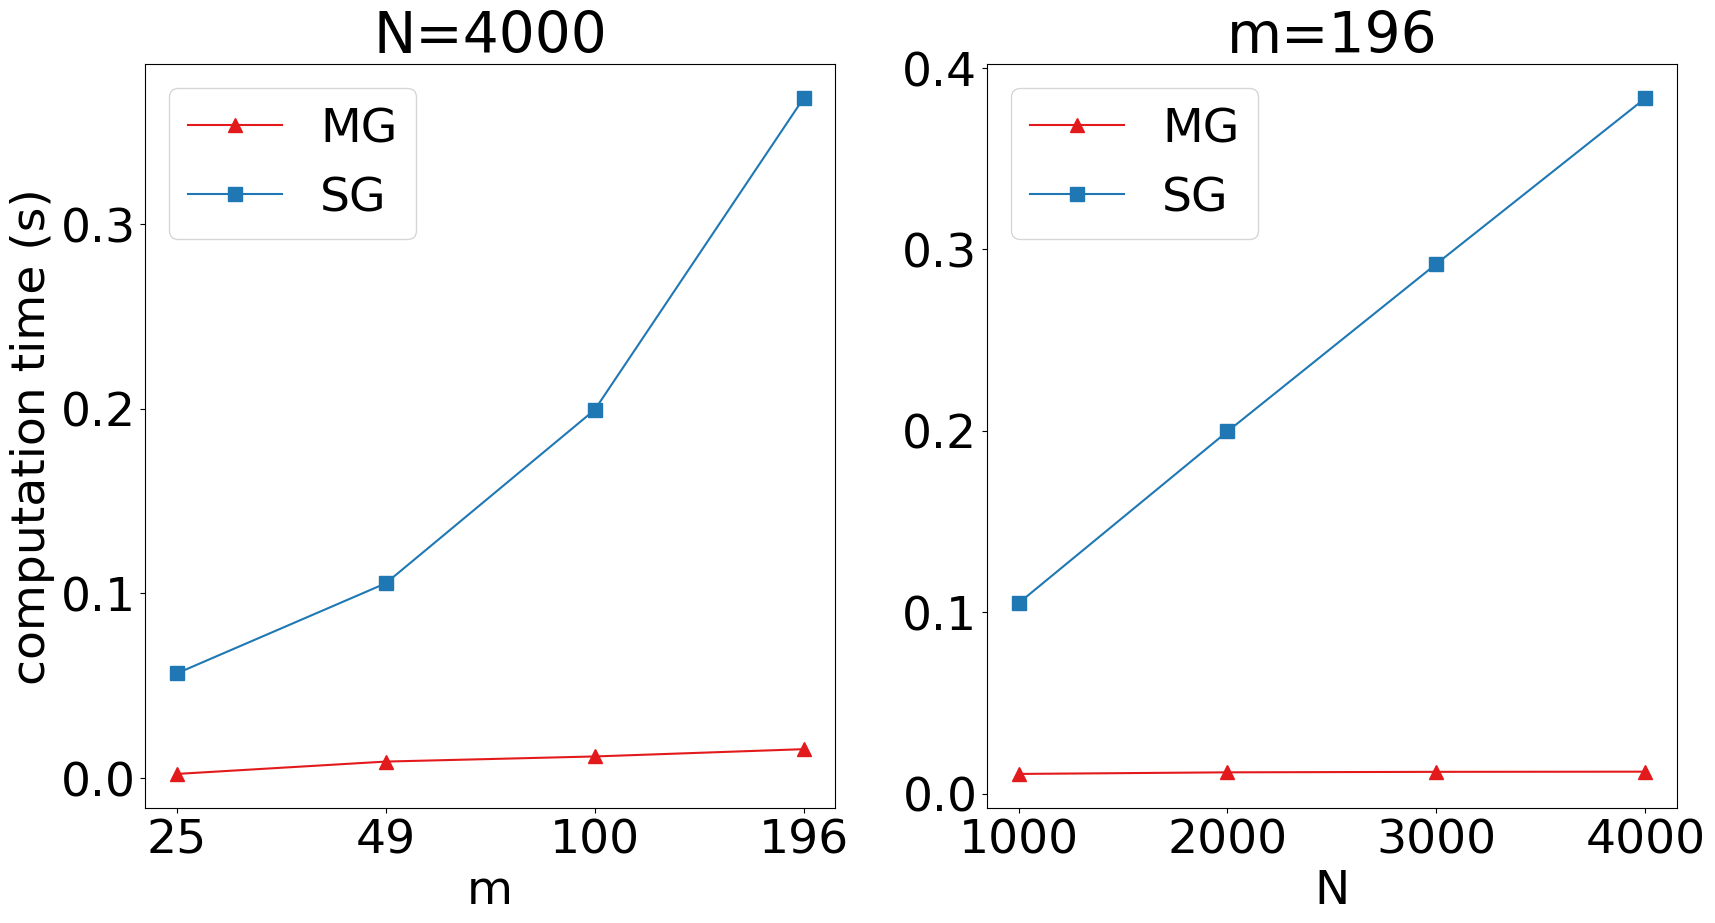

In [20]:
fig = plt.figure(figsize=(18, 18))
ax11 = plt.subplot(2,2,1)
ax12 = plt.subplot(2,2,2)
axes = [ax11, ax12]

width = 0.2
N_tick = 4
x_tick_NC = [i+1-width for i in range(N_tick)]
x_tick_FC = [i+1+width for i in range(N_tick)]

colors = [plt.cm.Paired(i) for i in range(20)]
color_FC = colors[1]
color_NC = colors[5]
color_NC_SoD = colors[6]

font_size=30

# axes[0].bar(x_tick_NC, NC_time_mean_N_fixed, yerr=NC_time_std_N_fixed, color=color_NC, width=2*width, label='neural chaos')
# axes[0].bar(x_tick_FC, FC_time_mean_N_fixed, yerr=FC_time_std_N_fixed, color=color_FC, width=2*width, label='fully connected')
# axes[0].set_xticks([i for i in range(1,N_tick+1)])
axes[0].plot(range(1,N_tick+1), NC_time_mean_N_fixed, color=color_NC, label='MG', marker='^', markersize=10)
axes[0].plot(range(1,N_tick+1), FC_time_mean_N_fixed, color=color_FC, label='SG', marker='s', markersize=10)
axes[0].set_xticks([i for i in range(1,N_tick+1)])
axes[0].set_xticklabels(torch.tensor(m_time).square().tolist())
axes[0].set_title(r'N=4000')#, fontdict={'fontsize':font_size})
axes[0].set_xlabel('m')
axes[0].set_ylabel('computation time (s)')
# axes[0].set_ylabel('time (ms)')
axes[0].legend()

# axes[1].bar(x_tick_NC, NC_time_mean_m_fixed, yerr=NC_time_std_m_fixed, color=color_NC, width=2*width, label='neural chaos')
# axes[1].bar(x_tick_FC, FC_time_mean_m_fixed, yerr=FC_time_std_m_fixed, color=color_FC, width=2*width, label='fully connected')
# axes[1].set_xticks([i for i in range(1,N_tick+1)])
axes[1].plot(range(1,N_tick+1), NC_time_mean_m_fixed, color=color_NC, label='MG', marker='^', markersize=10)
axes[1].plot(range(1,N_tick+1), FC_time_mean_m_fixed, color=color_FC, label='SG', marker='s', markersize=10)
axes[1].set_xticks([i for i in range(1,N_tick+1)])
axes[1].set_xticklabels(N_time)
axes[1].set_title(r'm=196')#, fontdict={'fontsize':font_size})
axes[1].set_xlabel('N')
# axes[1].set_ylabel('computation time (s)')
axes[1].legend()


fig.tight_layout()
fig.savefig('PDE_2D_l=1.0_total_time.pdf', bbox_inches='tight')
fig.show()

In [21]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

FC: 1.392e-02, 3.085e-01
NC one: 1.058e-02, 1.931e-01
NC multi: 1.018e-02, 3.038e-02


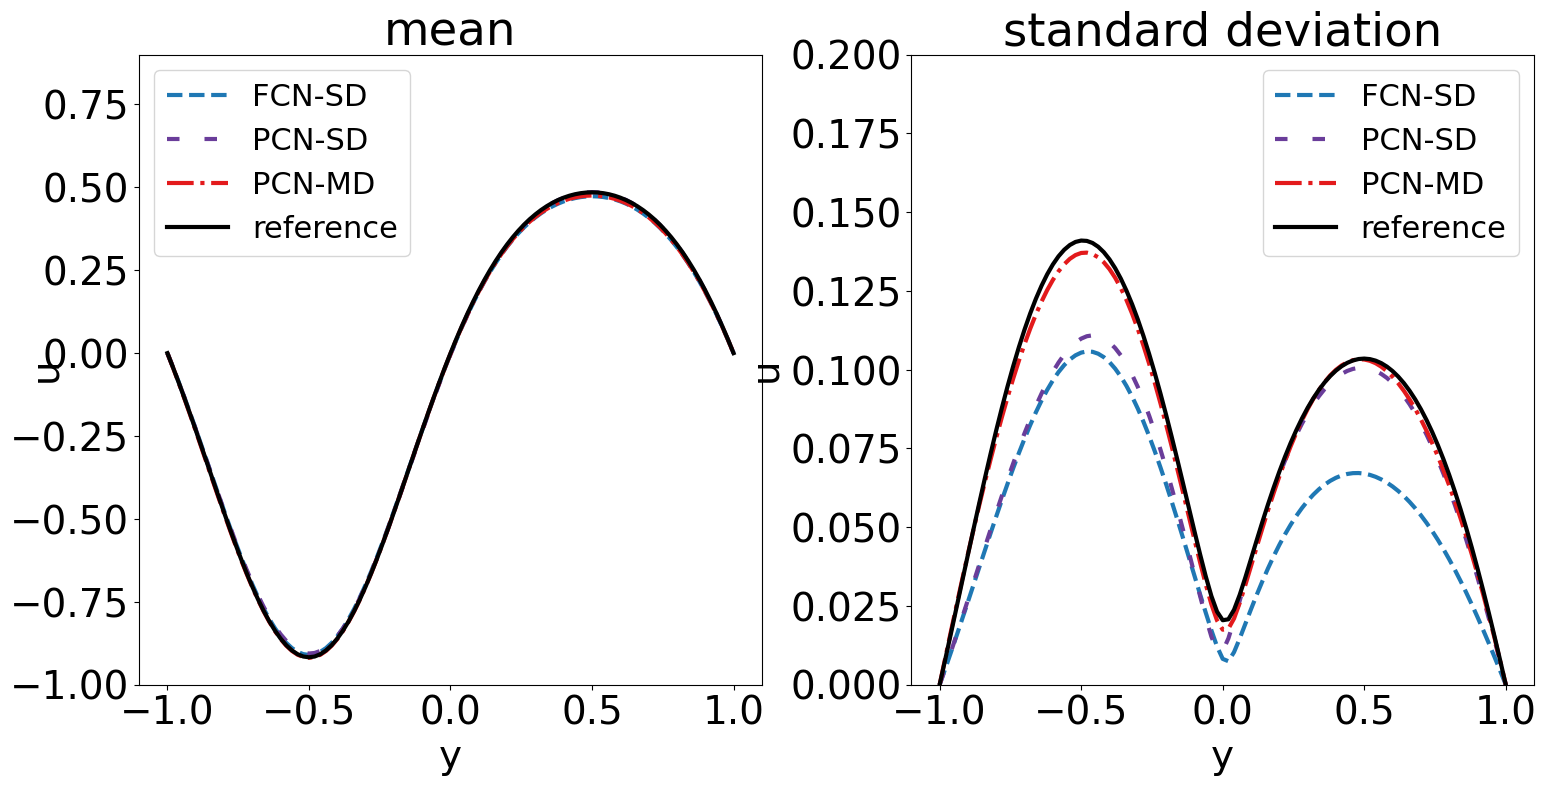

In [30]:
# fig_QoI, axes_QoI = plt.subplots(1,2, figsize=(22, 10))
fig_QoI = plt.figure(figsize=(18, 18),constrained_layout=False)
ax11 = plt.subplot(2,2,1)
ax12 = plt.subplot(2,2,2)
axes_QoI = [ax11, ax12]



x_ind = 75
start = 101*x_ind
end = 101*(x_ind+1)#x를 fix했을 때 단면 plot하기 용도
style = {'FC':'--','NC one':(0, (3, 6)),'NC multi':'-.'}
label_names = {'FC':'FCN-SD', 'NC one':'PCN-SD', 'NC multi':'PCN-MD'}
colors = [plt.cm.Paired(i) for i in range(20)]
cmap = {'FC':colors[1], 'NC one':colors[9], 'NC multi':colors[5]}

# marker = {'FC':None,'NC':'o','NC (SoD)':'^'}
for name in u_mean.keys():
    axes_QoI[0].plot(x_ref[1,start:end],u_mean[name][start:end], label=label_names[name], linestyle=style[name], color=cmap[name], linewidth=3)#, marker=marker[name])
    axes_QoI[1].plot(x_ref[1,start:end],u_std[name][start:end], label=label_names[name], linestyle=style[name], color=cmap[name], linewidth=3)#, marker=marker[name])
    er_mean = torch.norm(u_mean[name][start:end]-u_mean_ref[start:end])/torch.norm(u_mean_ref[start:end])
    er_std = torch.norm(u_std[name][start:end]-u_std_ref[start:end])/torch.norm(u_std_ref[start:end])
    print(name+f': {er_mean:.3e}, {er_std:.3e}')

axes_QoI[0].plot(x_ref[1,start:end],u_mean_ref[start:end], 'k', label='reference', linewidth=3)
axes_QoI[1].plot(x_ref[1,start:end],u_std_ref[start:end], 'k', label='reference', linewidth=3)

axes_QoI[0].set_title('mean')
axes_QoI[1].set_title('standard deviation')
axes_QoI[0].set_xlabel('y')
axes_QoI[1].set_xlabel('y')
axes_QoI[0].set_ylabel('u')
axes_QoI[1].set_ylabel('u')
axes_QoI[0].yaxis.set_label_coords(-.12, .5)
axes_QoI[0].set_ylim([-1,0.9])
axes_QoI[1].set_ylim([0,0.2])
# axes_QoI[1].set_yticks([0,0.05,0.1,0.15,0.2])
for i in range(2):
    axes_QoI[i].legend(prop={'size': 22})

# fig.tight_layout()
fig_QoI.subplots_adjust(wspace=0.24)
fig_QoI.savefig('PDE_2D_l=1.0_QoI_x=0.5.pdf', bbox_inches='tight')
fig_QoI.show()

In [23]:
# torch.manual_seed(0)
# cmap = 'rainbow'
# k_mean_heat = {}
# k_std_heat = {}

# fig_heat, axes_heat = plt.subplots(2,3, figsize=(18,12))

# k_mean_ref_heat = k_mean_ref.reshape(101,101).T.flipud()
# k_std_ref_heat = k_std_ref.reshape(101,101).T.flipud()
# minmax = [k_mean_ref_heat.min(),k_mean_ref_heat.max(),k_std_ref_heat.min(),k_std_ref_heat.max()]

# for name in k_mean.keys():
#     k_mean_heat[name] = k_mean[name].reshape(101,101).T.flipud()
#     k_std_heat[name] = k_std[name].reshape(101,101).T.flipud()
#     minmax[0] = torch.min(minmax[0],k_mean_heat[name].min())
#     minmax[1] = torch.max(minmax[1],k_mean_heat[name].max())
#     minmax[2] = torch.min(minmax[2],k_std_heat[name].min())
#     minmax[3] = torch.max(minmax[3],k_std_heat[name].max())



# pcm1 = axes_heat[0,0].pcolormesh(k_mean_ref_heat, cmap=cmap, vmin=minmax[0], vmax=minmax[1])
# pcm2 = axes_heat[1,0].pcolormesh(k_std_ref_heat, cmap=cmap, vmin=minmax[2], vmax=minmax[3])
# axes_heat[0,1].pcolormesh(k_mean_heat['one'], cmap=cmap, vmin=minmax[0], vmax=minmax[1])
# axes_heat[1,1].pcolormesh(k_std_heat['one'], cmap=cmap, vmin=minmax[2], vmax=minmax[3])
# axes_heat[0,2].pcolormesh(k_mean_heat['multi'], cmap=cmap, vmin=minmax[0], vmax=minmax[1])
# axes_heat[1,2].pcolormesh(k_std_heat['multi'], cmap=cmap, vmin=minmax[2], vmax=minmax[3])

# for i in range(2):
#     for j in range(3):
#         axes_heat[i,j].set_xticks([0,50,100])
#         axes_heat[i,j].set_xticklabels([-1,0,1])
#         axes_heat[i,j].set_yticks([0,50,100])
#         axes_heat[i,j].set_yticklabels([-1,0,1])

# axes_heat[0,0].set_ylabel('mean of k')
# axes_heat[1,0].set_ylabel('standard deviation of k')     

# axes_heat[0,0].set_title('reference')
# axes_heat[0,1].set_title('one-discriminator')
# axes_heat[0,2].set_title('multi-discirminator')
    
# fig_heat.colorbar(pcm1, ax=axes_heat[0, :], location='right')
# fig_heat.colorbar(pcm2, ax=axes_heat[1, :], location='right')
# fig_heat.savefig('PDE_2D_l=1.0_QoIheat_k.pdf', bbox_inches='tight')
# fig_heat.show()


In [24]:
# torch.manual_seed(0)
# cmap = 'rainbow'
# er_k_mean_heat = {}
# er_k_std_heat = {}

# fig_heat, axes_heat = plt.subplots(2,2, figsize=(18,12))

# minmax = None
# for name in k_mean.keys():
#     er_k_mean_heat[name] = torch.abs(k_mean_heat[name]-k_mean_ref_heat)
#     er_k_std_heat[name] = torch.abs(k_std_heat[name]-k_std_ref_heat)
#     if minmax==None:
#         minmax = [er_k_mean_heat[name].min(),er_k_mean_heat[name].max(),er_k_std_heat[name].min(),er_k_std_heat[name].max()]
#     else:
#         minmax[0] = torch.min(minmax[0],er_k_mean_heat[name].min())
#         minmax[1] = torch.max(minmax[1],er_k_mean_heat[name].max())
#         minmax[2] = torch.min(minmax[2],er_k_std_heat[name].min())
#         minmax[3] = torch.max(minmax[3],er_k_std_heat[name].max())
    
# pcm1 = axes_heat[0,0].pcolormesh(er_k_mean_heat['one'], cmap=cmap, vmin=minmax[0], vmax=minmax[1])
# pcm2 = axes_heat[1,0].pcolormesh(er_k_std_heat['one'], cmap=cmap, vmin=minmax[2], vmax=minmax[3])
# axes_heat[0,1].pcolormesh(er_k_mean_heat['multi'], cmap=cmap, vmin=minmax[0], vmax=minmax[1])
# axes_heat[1,1].pcolormesh(er_k_std_heat['multi'], cmap=cmap, vmin=minmax[2], vmax=minmax[3])


# for i in range(2):
#     for j in range(2):
#         axes_heat[i,j].set_xticks([0,50,100])
#         axes_heat[i,j].set_xticklabels([-1,0,1])
#         axes_heat[i,j].set_yticks([0,50,100])
#         axes_heat[i,j].set_yticklabels([-1,0,1])

# axes_heat[0,0].set_ylabel('mean error of k')
# axes_heat[1,0].set_ylabel('standard deviation error of k')     

# axes_heat[0,0].set_title('one-discriminator')
# axes_heat[0,1].set_title('multi-discirminator')
    
# fig_heat.colorbar(pcm1, ax=axes_heat[0, :], location='right')
# fig_heat.colorbar(pcm2, ax=axes_heat[1, :], location='right')
# fig_heat.savefig('PDE_2D_l=1.0_QoIerror_k.pdf', bbox_inches='tight')
# fig_heat.show()


In [25]:
import matplotlib
matplotlib.rcParams.update({'font.size': 28})

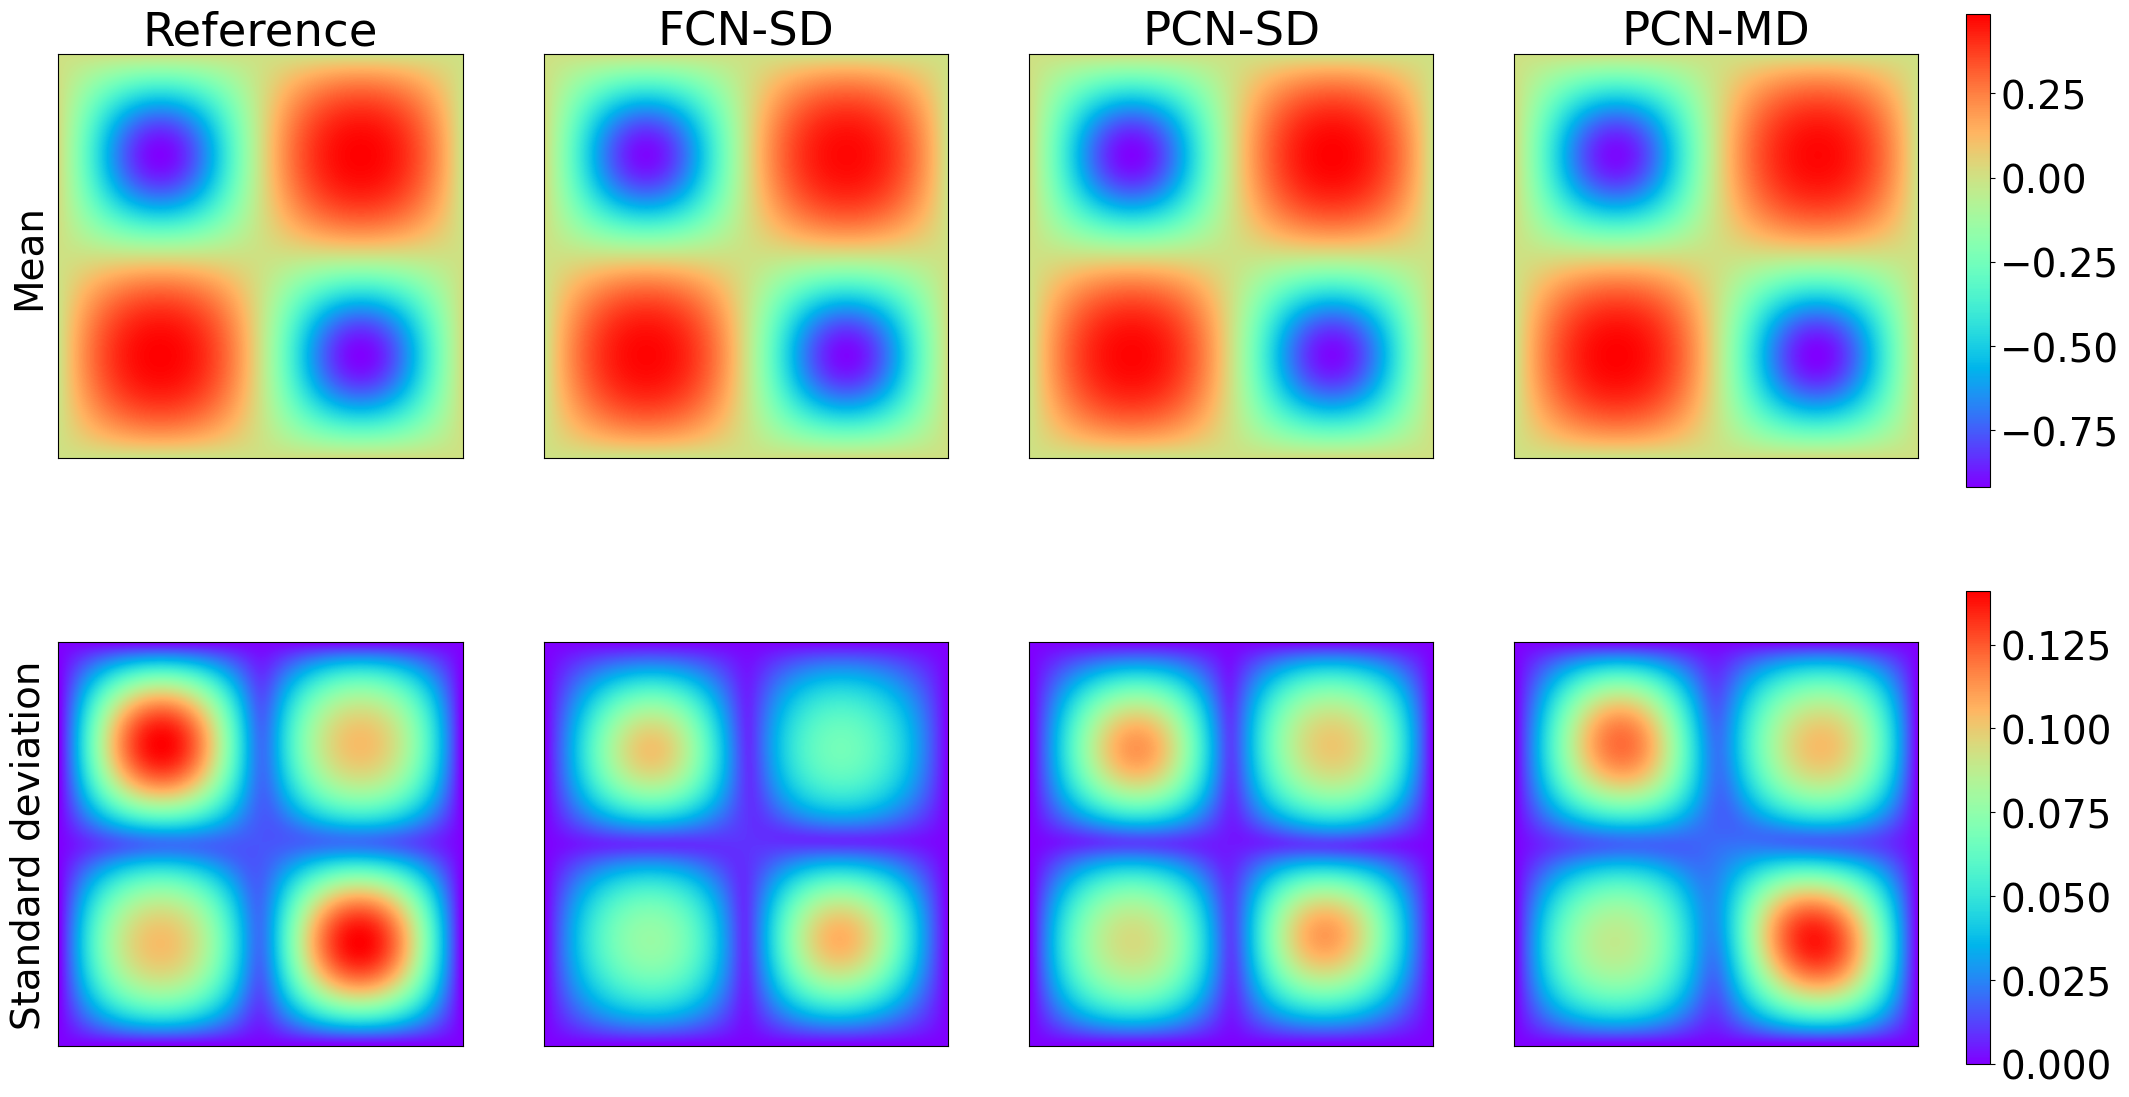

In [29]:
torch.manual_seed(0)
cmap = 'rainbow'
u_mean_heat = {}
u_std_heat = {}

fig_heat, axes_heat = plt.subplots(2,4, figsize=(24,14))
cbar_ax = fig_heat.add_axes([.92, .54, .01, .338])
cbar_ax2 = fig_heat.add_axes([.92, .128, .01, .338])

u_mean_ref_heat = u_mean_ref.reshape(101,101).T.flipud()
u_std_ref_heat = u_std_ref.reshape(101,101).T.flipud()
minmax = [u_mean_ref_heat.min(),u_mean_ref_heat.max(),u_std_ref_heat.min(),u_std_ref_heat.max()]

for name in u_mean.keys():
    u_mean_heat[name] = u_mean[name].reshape(101,101).T.flipud()
    u_std_heat[name] = u_std[name].reshape(101,101).T.flipud()
    minmax[0] = torch.min(minmax[0],u_mean_heat[name].min())
    minmax[1] = torch.max(minmax[1],u_mean_heat[name].max())
    minmax[2] = torch.min(minmax[2],u_std_heat[name].min())
    minmax[3] = torch.max(minmax[3],u_std_heat[name].max())


cbar_mean = axes_heat[0,0].imshow(u_mean_ref_heat, cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
cbar_std = axes_heat[1,0].imshow(u_std_ref_heat, cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
axes_heat[0,1].imshow(u_mean_heat['FC'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
axes_heat[1,1].imshow(u_std_heat['FC'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
axes_heat[0,2].imshow(u_mean_heat['NC one'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
axes_heat[1,2].imshow(u_std_heat['NC one'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
axes_heat[0,3].imshow(u_mean_heat['NC multi'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
axes_heat[1,3].imshow(u_std_heat['NC multi'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
fig_heat.colorbar(cbar_mean, cax=cbar_ax)
fig_heat.colorbar(cbar_std, cax=cbar_ax2)

for i in range(2):
    for j in range(4):
        axes_heat[i,j].set_xticks([])
        axes_heat[i,j].set_yticks([])

axes_heat[0,0].set_ylabel('Mean')
axes_heat[1,0].set_ylabel('Standard deviation')     

axes_heat[0,0].set_title('Reference')
axes_heat[0,1].set_title('FCN-SD')
axes_heat[0,2].set_title('PCN-SD')
axes_heat[0,3].set_title('PCN-MD')
    
fig_heat.savefig('PDE_2D_l=1.0_QoIheat_u.pdf', bbox_inches='tight')
fig_heat.show()


In [27]:
# torch.manual_seed(0)
# cmap = 'rainbow'
# er_u_mean_heat = {}
# er_u_std_heat = {}

# fig_heat, axes_heat = plt.subplots(2,3, figsize=(18,12))
# cbar_ax = fig_heat.add_axes([.92, .54, .01, .338])
# cbar_ax2 = fig_heat.add_axes([.92, .128, .01, .338])

# minmax = None
# for name in u_mean.keys():
#     er_u_mean_heat[name] = torch.abs(u_mean_heat[name]-u_mean_ref_heat)
#     er_u_std_heat[name] = torch.abs(u_std_heat[name]-u_std_ref_heat)
#     if minmax==None:
#         minmax = [er_u_mean_heat[name].min(),er_u_mean_heat[name].max(),er_u_std_heat[name].min(),er_u_std_heat[name].max()]
#     else:
#         minmax[0] = torch.min(minmax[0],er_u_mean_heat[name].min())
#         minmax[1] = torch.max(minmax[1],er_u_mean_heat[name].max())
#         minmax[2] = torch.min(minmax[2],er_u_std_heat[name].min())
#         minmax[3] = torch.max(minmax[3],er_u_std_heat[name].max())
    
# cbar_mean = axes_heat[0,0].imshow(er_u_mean_heat['FC'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
# cbar_std = axes_heat[1,0].imshow(er_u_std_heat['FC'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
# axes_heat[0,1].imshow(er_u_mean_heat['NC one'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
# axes_heat[1,1].imshow(er_u_std_heat['NC one'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
# axes_heat[0,2].imshow(er_u_mean_heat['NC multi'], cmap=cmap, vmin=minmax[0], vmax=minmax[1], interpolation='gaussian')
# axes_heat[1,2].imshow(er_u_std_heat['NC multi'], cmap=cmap, vmin=minmax[2], vmax=minmax[3], interpolation='gaussian')
# fig_heat.colorbar(cbar_mean, cax=cbar_ax)
# fig_heat.colorbar(cbar_std, cax=cbar_ax2)

# for i in range(2):
#     for j in range(3):
#         axes_heat[i,j].set_xticks([0,50,100])
#         axes_heat[i,j].set_xticklabels([-1,0,1])
#         axes_heat[i,j].set_yticks([0,50,100])
#         axes_heat[i,j].set_yticklabels([-1,0,1])

# axes_heat[0,0].set_ylabel('Mean error')
# axes_heat[1,0].set_ylabel('Standard deviation error')     

# axes_heat[0,0].set_title('SG-SD')
# axes_heat[0,1].set_title('MG-SD')
# axes_heat[0,2].set_title('MGD')
    
# fig_heat.savefig('PDE_2D_l=1.0_QoIerror_u.pdf', bbox_inches='tight')
# fig_heat.show()


In [28]:
torch.norm(er_u_mean_heat['FC'])/torch.norm(u_mean_ref_heat)

NameError: name 'er_u_mean_heat' is not defined

In [ ]:
torch.norm(er_u_mean_heat['NC multi'])/torch.norm(u_mean_ref_heat)

In [ ]:
torch.norm(er_u_std_heat['FC'])/torch.norm(u_std_ref_heat)

In [ ]:
torch.norm(er_u_std_heat['NC multi'])/torch.norm(u_std_ref_heat)